In [1]:
import os
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Explicação

Nesse ultimo Script, os dados são lidos e são treinados modelos para cada pré-processamento. 

# Functions

In [2]:
def balanceData(new_df, p_neg=0.7):
    n_pos = (new_df.y == 1).sum()
    n_neg = int(round(n_pos*p_neg/(1 - p_neg)))

    pos_df = new_df[new_df.y == 1]
    neg_df = new_df[new_df.y == 0]
    idx = np.random.choice(neg_df.index, replace=False, size=n_neg)
    neg_df = neg_df.loc[idx]

    return pd.concat([pos_df, neg_df], axis=0)

# IO

In [3]:
### Leitura dos dados

df = pd.DataFrame([])
sub = 8
for i in range(1,5):
    new_df = pd.read_parquet(f"../DATA_TIDY/subject {sub}/signal_{sub}_{i}.parquet")
    new_df = balanceData(new_df, 0.8)
    df = pd.concat([df, new_df], axis=0, sort=True)

In [4]:
### Separação dos dados

cca_columns = []
pca_columns = []
ica_columns = []

for col in df.columns:
    if "CCA" in col:
        cca_columns.append(col)
        
    elif "PCA" in col:
        pca_columns.append(col)
    
    elif "ICA" in col:
        ica_columns.append(col)
        
W_cca = df[cca_columns].values
W_pca = df[pca_columns].values
W_ica = df[ica_columns].values
y_w = df.y.values

del df

In [5]:
from sklearn.model_selection import train_test_split

rs = None#52

C_train, C_test, c_train, c_test = train_test_split(W_cca, y_w, stratify=y_w, random_state=rs)
P_train, P_test, p_train, p_test = train_test_split(W_pca, y_w, stratify=y_w, random_state=rs)
I_train, I_test, i_train, i_test = train_test_split(W_ica, y_w, stratify=y_w, random_state=rs)

In [6]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

In [7]:
%%time

kernel = 'rbf'
C = 1
model_pca = SVC(kernel=kernel, C=C, probability=True).fit(P_train, p_train)
print("PCA done")
model_ica = SVC(kernel=kernel, C=C, probability=True).fit(I_train, i_train)
print("ICA done")
model_cca = SVC(kernel=kernel, C=C, probability=True).fit(C_train, c_train)
print("CCA done")


# model_pca = GradientBoostingClassifier().fit(P_train, p_train)
# print("PCA done")
# model_ica = GradientBoostingClassifier().fit(I_train, i_train)
# print("ICA done")
# model_cca = GradientBoostingClassifier().fit(C_train, c_train)
# print("CCA done")

PCA done
ICA done
CCA done
Wall time: 6.42 s


In [8]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

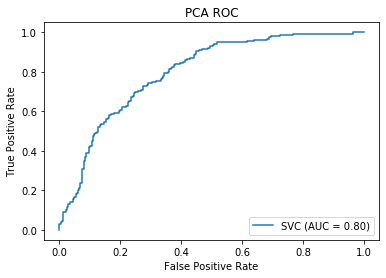

In [9]:
plot_roc_curve(model_pca, P_test, p_test)
plt.title("PCA ROC")
plt.show()

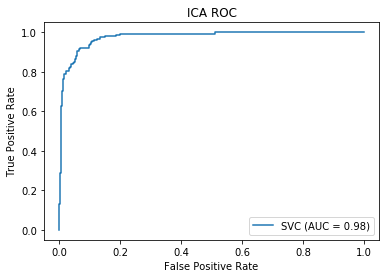

In [10]:
plot_roc_curve(model_ica, I_test, i_test)
plt.title("ICA ROC")
plt.show()

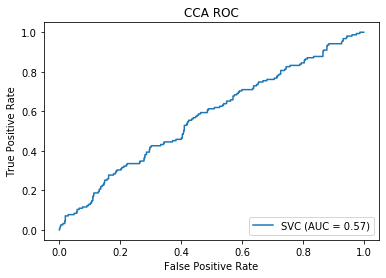

In [11]:
plot_roc_curve(model_cca, C_test, c_test)
plt.title("CCA ROC")
plt.show()

In [12]:
### Salva os modelos

import pickle

with open('model_pca.pkl', 'wb') as f:
    pickle.dump(model_pca, f)
    
with open('model_ica.pkl', 'wb') as f:
    pickle.dump(model_ica, f)
    
with open('model_cca.pkl', 'wb') as f:
    pickle.dump(model_cca, f)

In [13]:
t_pca = model_pca.predict_proba(P_test)[:,1]
t_ica = model_ica.predict_proba(I_test)[:,1]
t_cca = model_cca.predict_proba(C_test)[:,1]

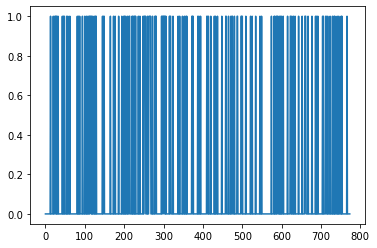

In [14]:
plt.plot(p_test)

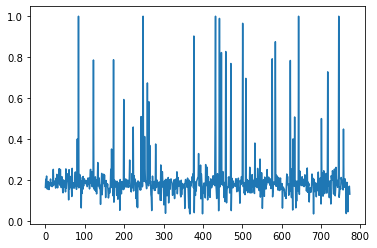

In [15]:
plt.plot(t_pca)

In [19]:
### Definindo Threshold
# Nas células abaixo, são criados os thresholds de cada modelo.
# Para isso, se dá um custo para falsos positivos (fp_c) e 
# um custo para falsos negativos (fn_c). Baseado nesses custos,
# se encontra o melhor threshold.
# Printa o threshold, especificidade e sensibilidade.

In [16]:
fp_c = 1
fn_c = 1

min_val = None
min_t = None

for t in np.arange(0,1,0.01):
    y_predict = t_pca >= t
    FP = np.sum(p_test[y_predict == 1] == 0)
    TP = np.sum(p_test[y_predict == 1] == 1)
    FN = np.sum(y_predict[p_test == 1] == 0)
    TN = np.sum(y_predict[p_test == 0] == 0)
    
    cost = fp_c*FP + fn_c*FN
    if min_val is None or min_val > cost:
        min_val = cost
        min_t = [t, FP, FN, TN, TP]

t, FP, FN, TN, TP = min_t

# Threshold, Specificity, Sensibility
t, TN/(FP + TN), TP/(FN + TP)

(0.51, 0.9886914378029079, 0.09032258064516129)

In [17]:
fp_c = 1
fn_c = 1

min_val = None
min_t = None

for t in np.arange(0,1,0.01):
    y_predict = t_ica >= t
    FP = np.sum(i_test[y_predict == 1] == 0)
    TP = np.sum(i_test[y_predict == 1] == 1)
    FN = np.sum(y_predict[i_test == 1] == 0)
    TN = np.sum(y_predict[i_test == 0] == 0)
    
    cost = fp_c*FP + fn_c*FN
    if min_val is None or min_val > cost:
        min_val = cost
        min_t = [t, FP, FN, TN, TP]

t, FP, FN, TN, TP = min_t

# Threshold, Specificity, Sensibility
t, TN/(FP + TN), TP/(FN + TP)

(0.6900000000000001, 0.9854604200323102, 0.7806451612903226)

In [18]:
fp_c = 1
fn_c = 1

min_val = None
min_t = None

for t in np.arange(0,1,0.01):
    y_predict = t_cca >= t
    FP = np.sum(c_test[y_predict == 1] == 0)
    TP = np.sum(c_test[y_predict == 1] == 1)
    FN = np.sum(y_predict[c_test == 1] == 0)
    TN = np.sum(y_predict[c_test == 0] == 0)
    
    cost = fp_c*FP + fn_c*FN
    if min_val is None or min_val > cost:
        min_val = cost
        min_t = [t, FP, FN, TN, TP]

t, FP, FN, TN, TP = min_t

# Threshold, Specificity, Sensibility
t, TN/(FP + TN), TP/(FN + TP)

(0.34, 0.9951534733441034, 0.025806451612903226)